In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

/Users/Jian/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import re

In [3]:
import datetime

In [4]:
import os

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from plotting import *

In [7]:
LOSS_INDEX = 3

## Acquisition

### Load logs from selected experiment

In [8]:
def get_all_configs(experiment_directory, n_workers, n_groups):
    '''
    n_groups is a list
    '''
    parameter_values = {}

    all_configs = []

    if not type(experiment_directory) == list:
        experiment_directory = [experiment_directory]

    for this_exp_dir in experiment_directory:
        print
        print 'From directory ' + this_exp_dir
        for fname in os.listdir(this_exp_dir):
            if fname[-4:]!='.log':
                print fname
                continue
            n_group_fname = int(fname.split("G=")[1].split("_")[0] )
            if n_group_fname not in n_groups:
                continue
            assert(fname[-4:]=='.log')
            parameter_strings = fname[:-4].split('_')
            print 'Loading ' + fname
            for pstring in parameter_strings:
                p,v = pstring.split('=')
                parameter_values[p] = float(v)
                if p=='W':
                    assert(int(v)==n_workers)
            print this_exp_dir + '/' + fname
            all_lines = load_results(this_exp_dir + '/' + fname)
            all_configs.append([parameter_values.copy(), all_lines])
    return all_configs

In [9]:
def get_he_se_numbers_from_log_lines(all_lines,n,g,group_batch=True):

    all_seconds, all_losses= get_times_losses(all_lines)

    all_worker_id = [line[1] for line in all_lines]
    all_n_iter =[line[2] for line in all_lines]
    
    all_seconds = np.array(all_seconds)
    all_losses = np.array(all_losses)
    all_worker_id = np.array(all_worker_id)
    all_n_iter = np.array(all_n_iter)
    
    batch_per_group = []
    time_per_group = []
    max_iter_per_group = np.ones( (g,) ) * -1
    min_iter_per_group = np.ones( (g,) ) * all_seconds.size
    max_time_per_group = np.ones( (g,) ) * -1
    min_time_per_group = np.ones( (g,) ) * all_seconds[-1]
    all_num_batches = 0
    all_time_compute = 0
    for i in range(n):
        iter_id = all_n_iter[np.logical_and(np.logical_and(all_worker_id == i, all_seconds < 80000), all_seconds > 0) ]
        seconds = all_seconds[np.logical_and(np.logical_and(all_worker_id == i, all_seconds < 80000), all_seconds > 0) ]
        if group_batch:
            raise Exception("TO BE IMPLEMENTED")
            # Each group is responsible of a mini-batch
#             total_batches=g*(np.max(iter_id)-np.min(iter_id) )
        else:
            # Each worker is responsible for a mini-batch
            if iter_id.size == 0:
#                 print("no log available from node ", i)
                continue
            else:
                assert n % g == 0
                group_id = i / (n / g)
                max_iter_per_group[group_id] = max(max_iter_per_group[group_id], np.max(iter_id) )
                min_iter_per_group[group_id] = min(min_iter_per_group[group_id], np.min(iter_id) )
                max_time_per_group[group_id] = max(max_time_per_group[group_id], np.max(seconds) )
                min_time_per_group[group_id] = min(min_time_per_group[group_id], np.min(seconds) )
            
    for i in range(g):
        assert n % g == 0
        n_worker_per_group = n / g
        
#         print max_iter_per_group[i], min_iter_per_group[i], max_time_per_group[i], min_time_per_group[i]
        if max_iter_per_group[i] == -1:
            print("no log for group ", i)
            continue
        
        all_num_batches += n_worker_per_group * (max_iter_per_group[i] - min_iter_per_group[i] )
        batch_per_group.append(max_iter_per_group[i] - min_iter_per_group[i] )
        all_time_compute += n_worker_per_group * (max_time_per_group[i] - min_time_per_group[i] )
        time_per_group.append(max_time_per_group[i] - min_time_per_group[i] )
            
#     plt.figure()
#     print time_per_group
#     plt.plot(time_per_group)
#     plt.show()
    

    seconds_per_batch = all_time_compute/all_num_batches/n
    
    return seconds_per_batch, all_num_batches, all_time_compute

In [10]:
def plot_HE_curve(all_seconds_per_batch, pdf_file=None):
    all_seconds_per_batch = np.array(all_seconds_per_batch)
    plt.plot(np.array(all_g),all_seconds_per_batch/all_seconds_per_batch[0],'o-', linewidth=3)
    plt.grid()
    plt.ylabel('HE Penalty', fontsize=21)
    plt.axis([None, None, 0, 1]);
    plt.xlabel('Number of trees (groups)', fontsize=21)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tight_layout()
    if pdf_file != None:
        plt.savefig(pdf_file)

In [11]:
def get_per_sample_time(n_workers, batch_size, use_group_batch_size, all_g, experiment_directory):
    # if using group batch size, batch_size equals to the samples per-iteration for the whole group
    # if using worker batch size, batch_size equals to the samples per-iteration for each worker
    all_configs = get_all_configs(experiment_directory, n_workers, all_g)
    best_configs = get_best_config_per_group(n_workers, all_configs, W=1)
    per_sample_time = []
    for G in all_g:
        res = get_he_se_numbers_from_log_lines(best_configs[G][1], n_workers, G, group_batch=use_group_batch)
        per_sample_time.append(res[0] / batch_size )
    per_sample_time = min(per_sample_time)
    return per_sample_time

In [12]:
def get_dirs(path, tag):
#     print tag
    dir_list = [d for d in os.listdir(path) if os.path.isdir(path + d) and tag in d]
    print dir_list
    assert len(dir_list) == 1
    return dir_list[0]

In [13]:
base_dir = '/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/'

## Async branch 1-group scaling

In [14]:
per_sample_time = []
n_workers_list = [1,2,4,8,16,32,64,128,256,512]
batch_size = 4
use_group_batch = False

In [15]:
for n_workers in n_workers_list:
    all_g = [1, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    
#     print experiment_directory
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )
    
per_sample_time_1_group = per_sample_time
all_n_workers_1_group = n_workers_list

['w1_async_weak_b4_new_prof_W1_2017-01-20-13:28']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w1_async_weak_b4_new_prof_W1_2017-01-20-13:28
Loading W=1_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w1_async_weak_b4_new_prof_W1_2017-01-20-13:28/W=1_G=1_LR=0.0003_mu=0.0.log
193.0 2.0 135.513301 0.705304
['w2_async_weak_b4_new_prof_W2_2017-01-20-13:28']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w2_async_weak_b4_new_prof_W2_2017-01-20-13:28
Loading W=2_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w2_async_weak_b4_new_prof_W2_2017-01-20-13:28/W=2_G=1_LR=0.0003_mu=0.0.log
288.0 1.0 193.939732 0.49041
['w4_async_weak_b4_new_prof_W

In [16]:
print per_sample_time_1_group

[0.17645025785340315, 0.084254931184668994, 0.048286588104838706, 0.024071301588983053, 0.0099967133736559143, 0.0061916689453125002, 0.0031812370598432995, 0.0016184478283898305, 0.0010919070786349291, 0.00070934417908081798]


## Async branch 2-group scaling

In [17]:
per_sample_time = []
n_workers_list = [2,4,8,16,32,64,128,256,512]
batch_size = 4
use_group_batch = False

In [18]:
for n_workers in n_workers_list:
    all_g = [2, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )

per_sample_time_2_group = per_sample_time
all_n_workers_2_group = n_workers_list

['w2_async_weak_b4_new_prof_W2_2017-01-20-13:28']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w2_async_weak_b4_new_prof_W2_2017-01-20-13:28
Loading W=2_G=2_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w2_async_weak_b4_new_prof_W2_2017-01-20-13:28/W=2_G=2_LR=0.0003_mu=0.0.log
254.0 2.0 174.583989 0.685243
251.0 1.0 174.383623 0.002498
['w4_async_weak_b4_new_prof_W4_2017-01-20-13:33']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w4_async_weak_b4_new_prof_W4_2017-01-20-13:33
Loading W=4_G=2_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w4_async_weak_b4_new_prof_W4_2017-01-20-13:33/W=4_G=2_LR=0.0003_mu=0.0.log
313.0 1.0 239.503532 0.68344

In [19]:
print per_sample_time_2_group

[0.086723075448207163, 0.047837643700000002, 0.023753023696192054, 0.012199162238675957, 0.006128190104166667, 0.002456253431372549, 0.0010982606399536133, 0.00063132842870850902, 0.00043686970078966566]


## Async branch 8-group scaling

In [20]:
per_sample_time = []
n_workers_list = [8,16,32,64,128,256,512]
batch_size = 4
use_group_batch = False

In [21]:
for n_workers in n_workers_list:
    all_g = [8, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )

per_sample_time_8_group = per_sample_time
all_n_workers_8_group = n_workers_list

['w8_async_weak_b4_new_prof_W8_2017-01-20-13:38']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w8_async_weak_b4_new_prof_W8_2017-01-20-13:38
Loading W=8_G=8_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w8_async_weak_b4_new_prof_W8_2017-01-20-13:38/W=8_G=8_LR=0.0003_mu=0.0.log
258.0 1.0 182.707963 0.103143
259.0 1.0 182.123997 0.020643
259.0 1.0 182.123847 0.057331
259.0 1.0 182.129467 0.04983
259.0 1.0 182.555863 0.034238
259.0 2.0 182.177235 0.71717
259.0 1.0 182.187668 0.019603
259.0 1.0 182.532421 0.12438
['w16_async_weak_b4_new_prof_W16_2017-01-21-13:07']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w16_async_weak_b4_new_prof_W16_2017-01-21-13:07
Loading W=16_G=8_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell

In [22]:
print per_sample_time_8_group

[0.022087356374272553, 0.011974744201933856, 0.0060566434451608782, 0.0030517472566952419, 0.0011054992369673379, 0.00054111972367226107, 0.0002834903780390526]


## Async branch 16-group scaling

In [34]:
per_sample_time = []
n_workers_list = [16,32,64,128,256,512]
# n_workers_list = [512,]
batch_size = 4
use_group_batch = False

In [35]:
for n_workers in n_workers_list:
    all_g = [16, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )

per_sample_time_16_group = per_sample_time
all_n_workers_16_group = n_workers_list

['w16_async_weak_b4_new_prof_W16_2017-01-21-13:07']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w16_async_weak_b4_new_prof_W16_2017-01-21-13:07
Loading W=16_G=16_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w16_async_weak_b4_new_prof_W16_2017-01-21-13:07/W=16_G=16_LR=0.0003_mu=0.0.log
590.0 1.0 422.871053 1.019537
599.0 2.0 423.253344 0.725304
600.0 1.0 423.506049 0.071052
600.0 1.0 423.159349 0.098101
602.0 1.0 422.855043 0.120387
600.0 1.0 422.938336 0.11036
599.0 1.0 422.896045 0.12497
598.0 1.0 423.084971 0.110065
600.0 1.0 423.367342 0.093957
599.0 1.0 423.460929 0.079625
601.0 1.0 422.841754 0.074375
601.0 1.0 423.294657 0.050797
599.0 1.0 422.867648 0.090118
600.0 1.0 423.056171 0.050731
598.0 1.0 422.874395 0.085042
601.0 1.0 423.507777 0.035157
['w32_async_weak_b4_new_prof_W32_2017-01-20-15:35']

Fro

In [36]:
print per_sample_time_16_group

[0.011048353064589863, 0.0059699657651882884, 0.0028534321499622986, 0.001527963916909017, 0.00054879851398437175, 0.00027970475987515767]


## Async branch 32-group scaling

In [26]:
per_sample_time = []
n_workers_list = [32,64,128,256,512]
batch_size = 4
use_group_batch = False

In [27]:
for n_workers in n_workers_list:
    all_g = [32, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )

per_sample_time_32_group = per_sample_time
all_n_workers_32_group = n_workers_list

['w32_async_weak_b4_new_prof_W32_2017-01-20-15:35']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w32_async_weak_b4_new_prof_W32_2017-01-20-15:35
Loading W=32_G=32_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w32_async_weak_b4_new_prof_W32_2017-01-20-15:35/W=32_G=32_LR=0.0003_mu=0.0.log
843.0 1.0 609.462108 1.653172
869.0 1.0 609.139184 0.053638
869.0 1.0 609.704468 0.022807
870.0 1.0 609.497392 0.099782
867.0 1.0 609.257324 0.042406
869.0 1.0 609.166133 0.063083
868.0 1.0 609.436904 0.052783
869.0 1.0 609.016908 0.07944
867.0 1.0 609.409228 0.055817
871.0 1.0 609.375094 0.030057
868.0 1.0 609.661516 0.03258
868.0 1.0 609.257604 0.018085
867.0 1.0 609.589943 0.096499
868.0 1.0 609.267915 0.108691
866.0 1.0 609.267131 0.031478
868.0 1.0 609.062951 0.103793
865.0 1.0 609.147707 0.106292
866.0 1.0 609.129575 0.056

In [28]:
print per_sample_time_32_group

[0.0054993704337513083, 0.0029809704581381172, 0.001509492855444224, 0.00053713715643326817, 0.00029310157561896302]


## Async branch full async scaling

In [29]:
per_sample_time = []

In [30]:
n_workers_list = [1,2,4,8,16,32,64,128,256,512]
batch_size = 4
use_group_batch = False

In [31]:
for n_workers in n_workers_list:
    all_g = [n_workers, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )
    
per_sample_time_n_workers_group = per_sample_time
all_n_workers_n_workers_group = n_workers_list

['w1_async_weak_b4_new_prof_W1_2017-01-20-13:28']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w1_async_weak_b4_new_prof_W1_2017-01-20-13:28
Loading W=1_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w1_async_weak_b4_new_prof_W1_2017-01-20-13:28/W=1_G=1_LR=0.0003_mu=0.0.log
193.0 2.0 135.513301 0.705304
['w2_async_weak_b4_new_prof_W2_2017-01-20-13:28']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w2_async_weak_b4_new_prof_W2_2017-01-20-13:28
Loading W=2_G=2_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w2_async_weak_b4_new_prof_W2_2017-01-20-13:28/W=2_G=2_LR=0.0003_mu=0.0.log
254.0 2.0 174.583989 0.685243
251.0 1.0 174.383623 0.00249

In [37]:
print per_sample_time_n_workers_group

[0.17645025785340315, 0.086723075448207163, 0.044180571756114125, 0.022087356374272553, 0.011048353064589863, 0.0054993704337513083, 0.0027544456753445029, 0.0013766665693752992, 0.00068746287420779146, 0.0013816063363727635]


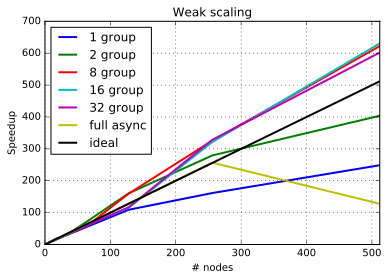

In [39]:
baseline = per_sample_time_1_group[0]
plt.plot(np.array(all_n_workers_1_group), baseline / np.array(per_sample_time_1_group), linewidth=2, label="1 group")
plt.plot(np.array(all_n_workers_2_group), baseline / np.array(per_sample_time_2_group), linewidth=2, label="2 group")
plt.plot(np.array(all_n_workers_8_group), baseline / np.array(per_sample_time_8_group), linewidth=2, label="8 group")
plt.plot(np.array(all_n_workers_16_group), baseline / np.array(per_sample_time_16_group), linewidth=2, label="16 group")
plt.plot(np.array(all_n_workers_32_group), baseline / np.array(per_sample_time_32_group), linewidth=2, label="32 group")
plt.plot(np.array(all_n_workers_n_workers_group), baseline / np.array(per_sample_time_n_workers_group), linewidth=2, label="full async")
plt.plot(all_n_workers_n_workers_group, all_n_workers_n_workers_group, linewidth=2, label="ideal")
plt.legend(loc="upper left")
plt.xlabel("# nodes")
plt.ylabel("Speedup")
plt.grid()
plt.xlim([0, 512])
# plt.ylim([0, 512])
plt.title("Weak scaling")

### test variability

In [40]:
base_dir = '/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/'

## Async branch 1-group scaling

In [44]:
per_sample_time = []
n_workers_list = [32]
batch_size = 4
use_group_batch = False

In [45]:
for n_workers in n_workers_list:
    all_g = [16, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    
#     print experiment_directory
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )
    
per_sample_time_1_group = per_sample_time
all_n_workers_1_group = n_workers_list

['w32_async_weak_b4_new_prof_W32_2017-01-20-15:35']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w32_async_weak_b4_new_prof_W32_2017-01-20-15:35
Loading W=32_G=16_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_01_21_6_server_wo_queue_512_new_proto_weak_scaling/w32_async_weak_b4_new_prof_W32_2017-01-20-15:35/W=32_G=16_LR=0.0003_mu=0.0.log
781.0 1.0 610.235951 0.100965
801.0 1.0 610.245321 0.046507
799.0 1.0 610.256994 0.033993
800.0 1.0 610.303947 0.039605
800.0 1.0 610.410984 0.630633
801.0 1.0 610.427896 0.679978
799.0 1.0 610.340765 0.611248
802.0 1.0 610.470139 0.659615
798.0 1.0 610.006062 0.057726
802.0 1.0 610.266309 0.051937
803.0 1.0 610.222196 0.003244
803.0 1.0 610.22063 0.618965
798.0 1.0 610.313109 0.020483
801.0 1.0 610.256767 0.017935
799.0 1.0 610.292862 0.572878
802.0 1.0 610.45269 0.017202


In [46]:
print per_sample_time_1_group
# [0.17644961067708334, 0.0844685243902439, 0.04829568447580645, 0.024073488665254238, 0.00999676999327957, 0.006191725991781656, 0.0031812437916516573, 0.001618453092790884, 0.0010919071852710641, 0.0003404413025269289]
# [0.17644961067708334, 0.042307969458987779, 0.012083666010895883, 0.0030104836397838067, 0.00062479812457997316, 0.00019349143724317676, 0.0075987840718401726, 0.00060392308411133164, 0.00013529982433103008, 8.0833984987803943e-05]

[0.0059699657651882884]


# Below this line the staff is not relevant

In [130]:
base_dir = '/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/'

## Async branch 1-group scaling

In [131]:
per_sample_time = []
n_workers_list = [256,]
batch_size = 4
use_group_batch = False

In [132]:
for n_workers in n_workers_list:
    all_g = [1, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    
    
    print experiment_directory
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )
    
per_sample_time_1_group = per_sample_time
all_n_workers_1_group = n_workers_list

['/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/w256_async_b4_W256_2016-12-22-14:46']

From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/w256_async_b4_W256_2016-12-22-14:46
.DS_Store
Loading W=256_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/w256_async_b4_W256_2016-12-22-14:46/W=256_G=1_LR=0.0003_mu=0.0.log
    stride: 2I1222 15:09:37.859104 232330 solver.cpp:291] [187] Iteration 1, loss = 10.7665

    stride: 2I1222 15:09:37.779243 245072 solver.cpp:291] [77] Iteration 1, loss = 55.7802

  name: "lossI1222 15:09:40.628485 245072 solver.cpp:291] [77] Iteration 2, loss = 0

    stride: 2I1222 15:09:40.652606 232257 solver.cpp:291] [186] Iteration 2, loss = 0

  name: "lossI1222 15:09:42.881649 232257 solver.cpp:291] [186] Iteration 3, loss = 0

  name: "lossI1222 15:09:46.636077 232627 solver.cpp:291] [72] Iteration 5, loss = 0



In [133]:
print per_sample_time_1_group

[0.0018539152802422134]


## Async branch 2-group scaling

In [134]:
per_sample_time = []
n_workers_list = [256,]
batch_size = 4
use_group_batch = False

In [135]:
for n_workers in n_workers_list:
    all_g = [2, ]
    experiment_directory = get_dirs(base_dir, tag="w"+str(n_workers)+"_")
    experiment_directory = [base_dir+experiment_directory]
    per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )

per_sample_time_2_group = per_sample_time
all_n_workers_2_group = n_workers_list


From directory /Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/w256_async_b4_W256_2016-12-22-14:46
.DS_Store
Loading W=256_G=1_LR=0.0003_mu=0.0.log
/Users/Jian/Data/research/gorden_bell/caffe-1/experiment/HEP/log_archiv_cori/dummy/log/w256_async_b4_W256_2016-12-22-14:46/W=256_G=1_LR=0.0003_mu=0.0.log
    stride: 2I1222 15:09:37.859104 232330 solver.cpp:291] [187] Iteration 1, loss = 10.7665

    stride: 2I1222 15:09:37.779243 245072 solver.cpp:291] [77] Iteration 1, loss = 55.7802

  name: "lossI1222 15:09:40.628485 245072 solver.cpp:291] [77] Iteration 2, loss = 0

    stride: 2I1222 15:09:40.652606 232257 solver.cpp:291] [186] Iteration 2, loss = 0

  name: "lossI1222 15:09:42.881649 232257 solver.cpp:291] [186] Iteration 3, loss = 0

  name: "lossI1222 15:09:46.636077 232627 solver.cpp:291] [72] Iteration 5, loss = 0

    stride: 2I1222 15:09:48.380045 221503 solver.cpp:291] [4] Iteration 6, loss = 0

    stride: 2I1222 15:09:48.418721 221737 

In [136]:
print per_sample_time_2_group

[0.0014727011198906845]


### 1 worker

In [18]:
n_workers = 1
use_group_batch = False
batch_size = 1
all_g = [1,]
experiment_directory='w1_master_W1_2016-12-20-02:16'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w1_master_W1_2016-12-20-02:16
Loading W=1_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w1_master_W1_2016-12-20-02:16/W=1_G=1_LR=0.0003_mu=0.0.log
[0.16924877504553731]


### 4 worker

In [19]:
n_workers = 4
use_group_batch = False
batch_size = 1
all_g = [1,2,4,]
experiment_directory='w4_async_per_worker_W4_2016-12-20-01:08'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w4_async_per_worker_W4_2016-12-20-01:08
Loading W=4_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w4_async_per_worker_W4_2016-12-20-01:08/W=4_G=1_LR=0.0003_mu=0.0.log
Loading W=4_G=2_LR=0.0003_mu=0.0.log
../log_archiv_cori/w4_async_per_worker_W4_2016-12-20-01:08/W=4_G=2_LR=0.0003_mu=0.0.log
Loading W=4_G=4_LR=0.0003_mu=0.0.log
../log_archiv_cori/w4_async_per_worker_W4_2016-12-20-01:08/W=4_G=4_LR=0.0003_mu=0.0.log
[0.04628588049853372, 0.034214421875000005, 0.054536240719910006]


### 16 worker

In [20]:
n_workers = 16
use_group_batch = False
batch_size = 1
all_g = [1,2,4,8,16]
experiment_directory='w16_async_per_worker_W16_2016-12-20-01:49'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory))


From directory ../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49
Loading W=16_G=16_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49/W=16_G=16_LR=0.0003_mu=0.0.log
Loading W=16_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49/W=16_G=1_LR=0.0003_mu=0.0.log
Loading W=16_G=2_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49/W=16_G=2_LR=0.0003_mu=0.0.log
Loading W=16_G=4_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49/W=16_G=4_LR=0.0003_mu=0.0.log
Loading W=16_G=8_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_async_per_worker_W16_2016-12-20-01:49/W=16_G=8_LR=0.0003_mu=0.0.log
[0.015922215458387515, 0.014282216787790698, 0.011960878951848249, 0.011319198090277777, 0.022907568973634652]


### 64 worker

In [21]:
n_workers = 64
use_group_batch = False
batch_size = 1
all_g = [1,2,4,8,16,32,64]
experiment_directory='w64_async_per_worker_W64_2016-12-20-00:10'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10
Loading W=64_G=16_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=16_LR=0.0003_mu=0.0.log
Loading W=64_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=1_LR=0.0003_mu=0.0.log
Loading W=64_G=2_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=2_LR=0.0003_mu=0.0.log
Loading W=64_G=32_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=32_LR=0.0003_mu=0.0.log
Loading W=64_G=4_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=4_LR=0.0003_mu=0.0.log
Loading W=64_G=64_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=64_LR=0.0003_mu=0.0.log
Loading W=64_G=8_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_async_per_worker_W64_2016-12-20-00:10/W=64_G=8_LR=0.0003_mu=0.0.log
[0.00462765067

In [22]:
per_sample_time_async = per_sample_time

## Master branch scaling

In [23]:
per_sample_time = []

### 1 worker

In [24]:
n_workers = 1
use_group_batch = False
batch_size = 1
all_g = [1,]
experiment_directory='w1_master_W1_2016-12-20-02:16'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w1_master_W1_2016-12-20-02:16
Loading W=1_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w1_master_W1_2016-12-20-02:16/W=1_G=1_LR=0.0003_mu=0.0.log
[0.16924877504553731]


### 4 worker

In [25]:
n_workers = 4
use_group_batch = False
batch_size = 1
all_g = [1,]
experiment_directory='w4_master_W4_2016-12-20-01:03'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w4_master_W4_2016-12-20-01:03
Loading W=4_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w4_master_W4_2016-12-20-01:03/W=4_G=1_LR=0.0003_mu=0.0.log
[0.04835493585192698]


### 16 worker

In [26]:
n_workers = 16
use_group_batch = False
batch_size = 1
all_g = [1,]
experiment_directory='w16_master_W16_2016-12-20-01:44'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory))


From directory ../log_archiv_cori/w16_master_W16_2016-12-20-01:44
Loading W=16_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w16_master_W16_2016-12-20-01:44/W=16_G=1_LR=0.0003_mu=0.0.log
[0.015674151729060913]


### 64 worker

In [27]:
n_workers = 64
use_group_batch = False
batch_size = 1
all_g = [1,]
experiment_directory='w64_master_W64_2016-12-20-00:05'
experiment_directory = [base_dir+experiment_directory]
per_sample_time.append(get_per_sample_time(n_workers, batch_size, use_group_batch, all_g, experiment_directory) )


From directory ../log_archiv_cori/w64_master_W64_2016-12-20-00:05
Loading W=64_G=1_LR=0.0003_mu=0.0.log
../log_archiv_cori/w64_master_W64_2016-12-20-00:05/W=64_G=1_LR=0.0003_mu=0.0.log
[0.0048237595942982455]


In [28]:
per_sample_time_master = per_sample_time

### plot weak scaling scaling number

[0.16924877504553731, 0.034214421875000005, 0.011319198090277777, 0.0038706594905878466]
[0.16924877504553731, 0.04835493585192698, 0.015674151729060913, 0.0048237595942982455]


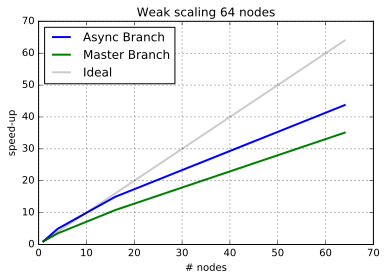

In [30]:
n_nodes = np.array( [1,4,16,64] )
print per_sample_time_async
speed_up = 1 / np.array(per_sample_time_async)
plt.plot(n_nodes, speed_up/speed_up[0], linewidth=2, label="Async Branch")
print per_sample_time_master
speed_up = 1 / np.array(per_sample_time_master)
plt.plot(n_nodes, speed_up/speed_up[0], linewidth=2, label="Master Branch")
plt.plot(n_nodes, n_nodes, linewidth=2, label="Ideal", color='k', alpha=0.2)
plt.title("Weak scaling 64 nodes")
plt.grid()
plt.xlabel("# nodes")
plt.ylabel("speed-up")
plt.legend(loc='upper left')
plt.show();